In [1]:
import numpy as np

from modelVelocity import ModelVelocity
from logProb import log_prob
from MCMC import MCMC

#from multiprocessing import get_context
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
#Read the measurements. 
data = np.loadtxt("data.dat")
sigma_obs = data[:,0]
sigma_obs_err = data[:,1]
r_ins = data[:,2]
r_outs = data[:,3]
sigma_Bs = data[:,4]

In [3]:
#Initialize the modeling object
modelv = ModelVelocity(sigma_Bs, r_ins, r_outs)

In [4]:
#Initial guesses. Order is n, log Mbulge, re bulge, log Mbh
x_init = np.array([4.0, 10.5, 1.5, 10.])

#Set the bounds.
x_min = np.array([0.50,  8., 0.25, 0.])
x_max = np.array([10.0, 12., 10.0, 11.])

#Set which parameters are fixed.
ifix  = np.zeros(x_init.shape, dtype=bool)
ifix[0] = True
ifix[2] = True

In [5]:
#Run the MCMC
myMCMC = MCMC(x_init, x_min, x_max, modelv, log_prob, sigma_obs, sigma_obs_err, ifix=ifix)
myMCMC.runMCMC()

100%|██████████| 2000/2000 [03:34<00:00,  9.30it/s]


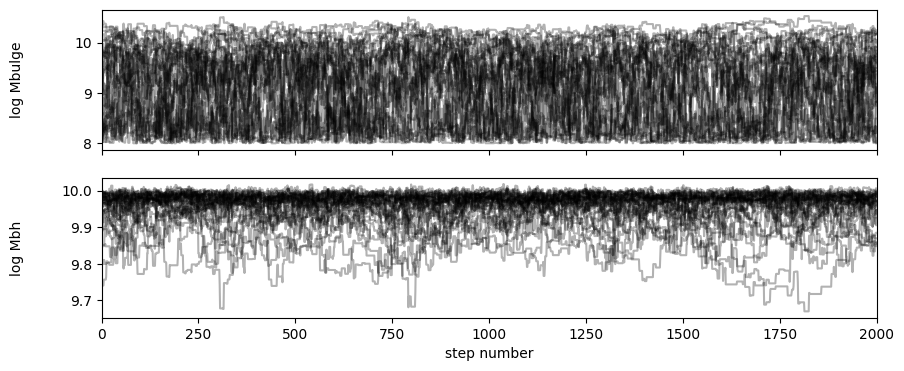

In [6]:
myMCMC.plotConvergence()

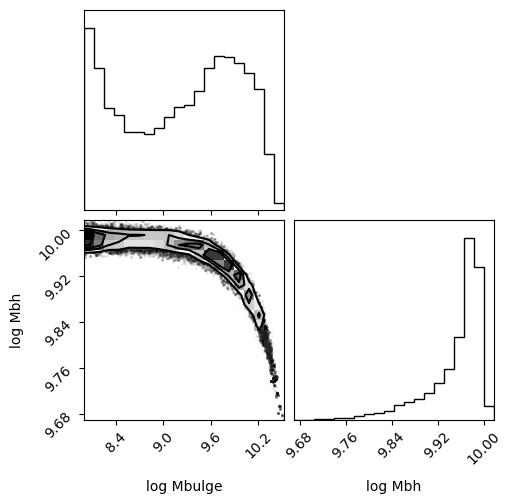

In [7]:
myMCMC.corner_plot()

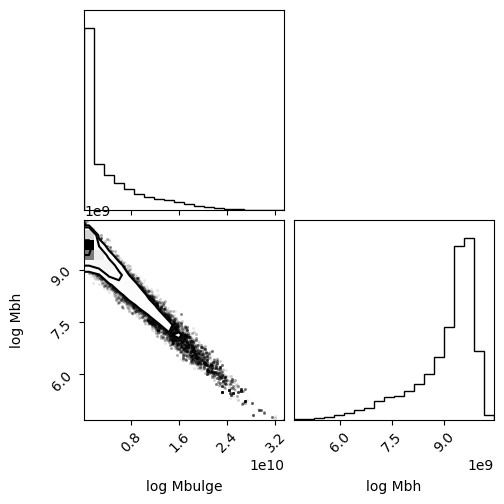

In [11]:
myMCMC.corner_plot(keep_log=False)

In [8]:
myMCMC.best_fit()

(array([4.        , 9.32670856, 1.5       , 9.97016887]), -3.4906718250824444)

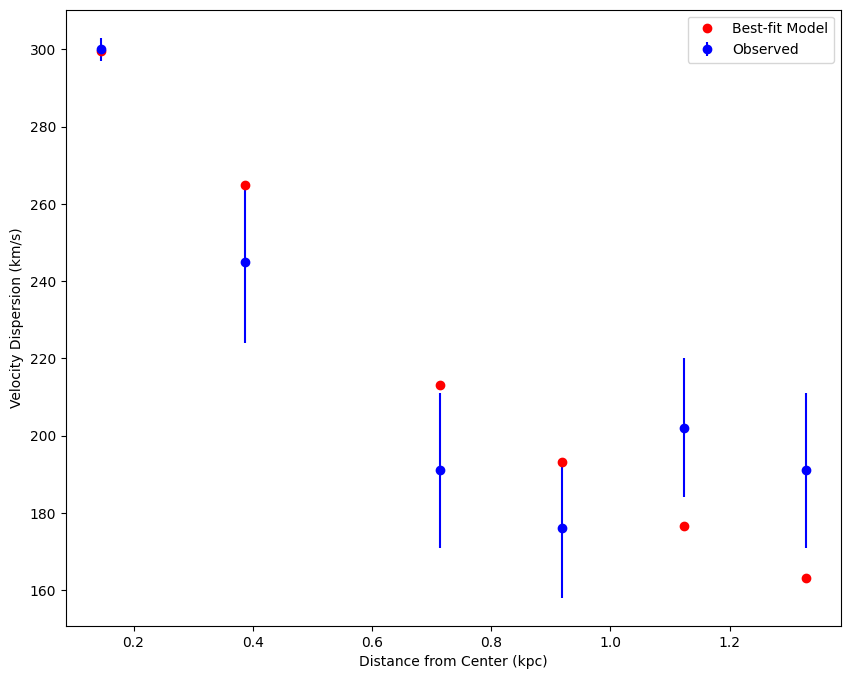

In [9]:
myMCMC.plot_bestfit()

In [10]:
myMCMC.save_flat_samples("MCMC_flatchain.txt")